# Regularyzacja w modelu regresji - zbiór `Hitter`

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Zadanie - `Hitter`

Zbiór `Hitter` (pakiet `ISLR`) zawiera dane z **Major League Baseball** z sezonu 1986 i 1987, zawierają 322 obserwacje na temat głównych zawodników scharakteryzowanym na podstawie następujących zmiennych: 

``AtBat``
   Number of times at bat in 1986

``Hits``
   Number of hits in 1986

``HmRun``
   Number of home runs in 1986

``Runs``
   Number of runs in 1986

``RBI``
   Number of runs batted in in 1986

``Walks``
   Number of walks in 1986

``Years``
   Number of years in the major leagues

``CAtBat``
   Number of times at bat during his career

``CHits``
   Number of hits during his career

``CHmRun``
   Number of home runs during his career

``CRuns``
   Number of runs during his career

``CRBI``
   Number of runs batted in during his career

``CWalks``
   Number of walks during his career

``League``
   A factor with levels ``A`` and ``N`` indicating player's league at
   the end of 1986

``Division``
   A factor with levels ``E`` and ``W`` indicating player's division at
   the end of 1986

``PutOuts``
   Number of put outs in 1986

``Assists``
   Number of assists in 1986

``Errors``
   Number of errors in 1986

``Salary``
   1987 annual salary on opening day in thousands of dollars

``NewLeague``
   A factor with levels ``A`` and ``N`` indicating player's league at
   the beginning of 1987

1. Dopasuj model regresji liniowej, w którym zmienną zależną jest zmienna `Salary` a pozostałe cechy zmiennymi niezależnymi.
Wyznacz ocenę dopasowania modelu korzystając z kroswalidacji 10-krotnej dla następujących miar:
   - błędu średniokwadratowego, 
   - mediany błędu bezwzględnego, 
   - wspóczynnik determinacji $R^2$.
    
    
2. Dopasuj model regresji grzbietowej:

   a) dla dowolnie wybranego parametru $\alpha$ i wyznacz ocenę doapsowania modelu przy użyciu kroswalidacji 10-krotnej dla błędu średniokwadratowego, mediany błędu bezwzględnego, i wspóczynnik determinacji $R^2$.
   
   b) znajdź optymalną wartość parametru $\alpha$ (`GridSearchCV`)
   
   c) sporządź wykres wartości współczynników regresji względem parametru $\alpha$.
   

3. Dopasuj model regresji Lasso:

   a) dla dowolnie wybranego parametru $\alpha$ i wyznacz ocenę doapsowania modelu przy użyciu kroswalidacji 10-krotnej dla błędu średniokwadratowego, mediany błędu bezwzględnego, i wspóczynnik determinacji $R^2$.
   
   b) znajdź optymalną wartość parametru $\alpha$ (`GridSearchCV`)
   
   c) sporządź wykres wartości współczynników regresji względem parametru $\alpha$.

In [3]:
hitters = sm.datasets.get_rdataset(dataname="Hitters", package="ISLR", cache=True)
# print(hitters.__doc__)

In [4]:
hitters.data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [5]:
hitters.data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    obje

In [6]:
hitters = hitters.data.dropna()
hitters = hitters.drop(['League', 'Division', 'NewLeague'], axis = 1)

In [7]:
## Podział zbioru na zmienne niezależne i zmienną zależną
X, y = hitters.iloc[:, hitters.columns != 'Salary'], hitters['Salary']

In [8]:
#zwykła regresja liniowa
model_linear_regression = LinearRegression()
model_linear_regression.fit(X, y)

LinearRegression()

In [9]:
#rozważamy miary MSE, MAE, R^2 obliczone przy koswalidacji 10krotnej
mse = -cross_val_score(estimator=model_linear_regression, X=X, y=y, scoring='neg_mean_squared_error', cv=10).mean()
mae = -cross_val_score(estimator=model_linear_regression, X=X, y=y, scoring='neg_median_absolute_error', cv=10).mean()
r2 = cross_val_score(estimator=model_linear_regression, X=X, y=y, scoring='r2', cv=10).mean()

results_linear_regression = {}
results_linear_regression['mse'] = mse
results_linear_regression['mae'] = mae
results_linear_regression['r2'] = r2

In [10]:
results_linear_regression

{'mae': 173.21567461796292,
 'mse': 118756.28241460072,
 'r2': 0.3261309242607547}

(array([108.,  50.,  49.,  27.,  11.,   7.,   2.,   6.,   1.,   2.]),
 array([  67.5 ,  306.75,  546.  ,  785.25, 1024.5 , 1263.75, 1503.  ,
        1742.25, 1981.5 , 2220.75, 2460.  ]),
 <a list of 10 Patch objects>)

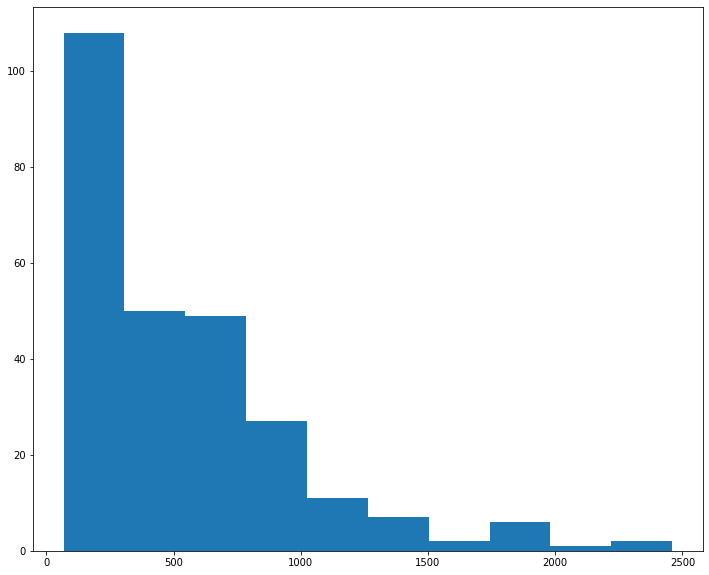

In [12]:
# MSE o wiele większe od MAE może być to spowodowane bardzo niesymetrycznym rozkładem y
plt.hist(y)

In [13]:
# Regresja z regularyzacja Ridge
model_ridge_regression = make_pipeline(
    StandardScaler(), 
    Ridge(alpha=1)
)

In [14]:
#rozważamy miary MSE, MAE, R^2 obliczone przy koswalidacji 10krotnej
def cv_model(model, X, y):
    mse = -cross_val_score(estimator=model, X=X, y=y, scoring='neg_mean_squared_error', cv=10).mean()
    mae = -cross_val_score(estimator=model, X=X, y=y, scoring='neg_median_absolute_error', cv=10).mean()
    r2 = cross_val_score(estimator=model, X=X, y=y, scoring='r2', cv=10).mean()

    results = {}
    results['mse'] = mse
    results['mae'] = mae
    results['r2'] = r2
    return results

In [ ]:
#lepsze dopasowanie za pomocą kroswalidacji niż w przypadku zwykłej regresji liniowej
cv_model(model_ridge_regression, X, y)

{'mae': 163.95230776776864,
 'mse': 116844.6017982421,
 'r2': 0.34173025725161926}

# `Gridsearch`

In [15]:
#wcześniej patrzyliśmy jak się to zachowuje dla ustalonej alphy
estimator_ridge = make_pipeline(
    StandardScaler(), 
    Ridge()
)

#grid bierze estymator i wyszukuje jak najlepszy jego parametr (w przypadku ridge czy lasso chodzi o parametr alpha)
grid = GridSearchCV(
    estimator=estimator_ridge, 
    param_grid = {'ridge__alpha': np.linspace(0.01, 10, 100)},
    scoring='neg_mean_squared_error',
    cv=10
)
#dopasowujemy model ridge dla alpha optymalnego dla danych na których uczymy model
grid.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([ 0.01      ,  0.11090909,  0.21181818,  0.31272727,  0.41363636,
        0.51454545,  0.61545455,  0.71636364,  0.81727273,  0.91818182,
        1.01909091,  1.12      ,  1.22090909,  1.32181818,  1.42272727,
        1.52363636,  1.62454545,  1.72545455,  1.82636364,  1.92727273,
        2.02818...
        6.56909091,  6.67      ,  6.77090909,  6.87181818,  6.97272727,
        7.07363636,  7.17454545,  7.27545455,  7.37636364,  7.47727273,
        7.57818182,  7.67909091,  7.78      ,  7.88090909,  7.98181818,
        8.08272727,  8.18363636,  8.28454545,  8.38545455,  8.48636364,
        8.58727273,  8.68818182,  8.78909091,  8.89      ,  8.99090909,
        9.09181818,  9.19272727,  9.29363636,  9.39454545,  9.49545455,
        9.59636364,  9.69727273,  9.79818182,  9.89909091, 10.

In [16]:
grid.best_params_ #najlepsza alpha

{'ridge__alpha': 1.8263636363636364}

In [ ]:
-grid.best_score_ #MSE

116735.61311212038

In [17]:
grid_best = grid.best_estimator_

# ridge = make_pipeline(
#     StandardScaler(), 
#     Ridge(alpha=grid.best_params_)
# ) - Ridge z najlepszą alphą

In [19]:
print(grid_best['ridge'].coef_)
grid_best['ridge'].intercept_ #współczynniki

[-278.91628529  279.23413707   -8.1903506    -4.48118841   22.5088868
  114.69263401  -42.38129766 -177.18166575  115.19049455   52.30653646
  288.83480788  124.197989   -159.29930532   81.38437236   46.01913446
  -21.95545652]


535.9258821292775

In [20]:
cv_model(grid.best_estimator_, X, y) # jeszcze mniejsze, ale nie dziwi to, skoro alphę szukamy tak, aby minimalizowała MSE na zbiorze kroswalidacyjnym.
#Przydałby się zbiór testowy

{'mae': 160.62366725288683,
 'mse': 116735.61311212038,
 'r2': 0.3460166242534291}

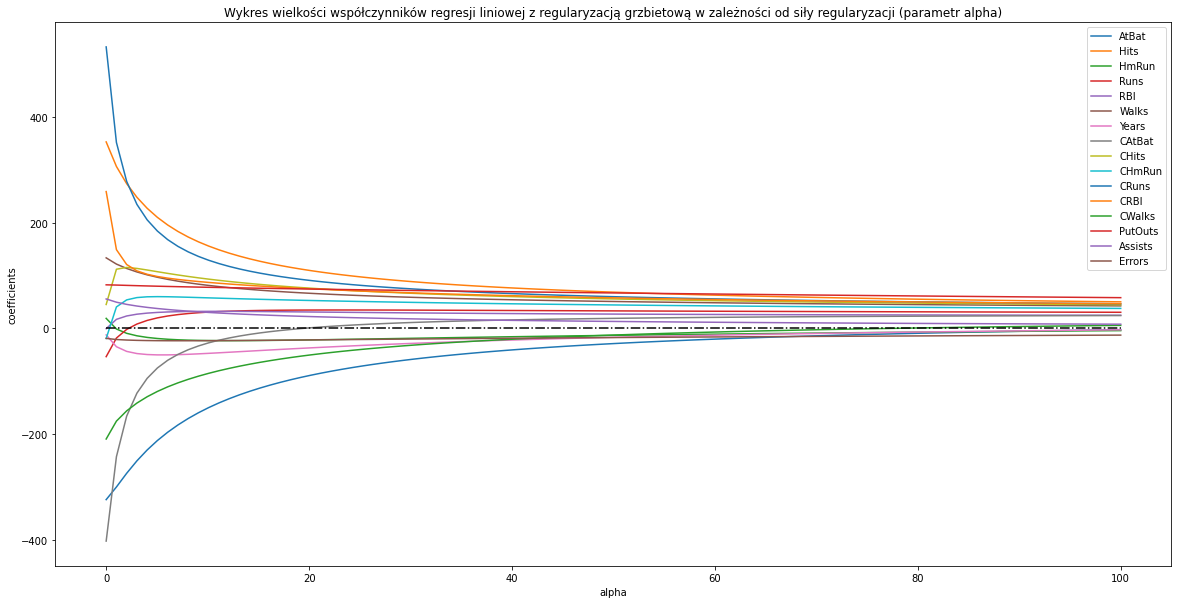

In [21]:
#2c
#patrzymy jak zmieniają się współczynniki beta ridge wraz ze wzrostem alphy 
plt.figure(figsize=(20, 10))

alpha_vec =  np.linspace(0, 100, 100)

coefs = []
for a in alpha_vec:
    model_ridge_regression = make_pipeline(
        StandardScaler(),
        Ridge(alpha = a)
    )
    model_ridge_regression.fit(X, y)
    coefs.append(model_ridge_regression.named_steps['ridge'].coef_)


plt.plot(alpha_vec, coefs)
plt.plot([np.min(alpha_vec), np.max(alpha_vec)], [0, 0], '-.', color = 'black')
plt.title('Wykres wielkości współczynników regresji liniowej z regularyzacją grzbietową w zależności od siły regularyzacji (parametr alpha)')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.legend(X.columns)
plt.show()

## Regresja wielomianowa z regularyzacją ridge

In [22]:
#teraz łączymy regresję wielomianową z regularyzacją ridge
poly_ridge_estimator = make_pipeline(
    PolynomialFeatures(),
    StandardScaler(),
    Ridge()
)
poly_ridge_estimator

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
#bierzemy siatkę potęg wielomianów i siatkę alph
grid2 = GridSearchCV(
    estimator=poly_ridge_estimator,
    param_grid={
        'polynomialfeatures__degree': [1, 2, 3, 4, 5],
        'ridge__alpha': np.linspace(0, 1, 10)
    },
    scoring='neg_mean_squared_error',
    cv=10
)

grid2.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'polynomialfeatures__degree': [1, 2, 3, 4, 5],
                         'ridge__alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             scoring='neg_mean_squared_error')

In [25]:
grid2.best_params_ #optymalne parametry

{'polynomialfeatures__degree': 2, 'ridge__alpha': 0.8888888888888888}

In [29]:
cv_model(grid2.best_estimator_, X, y) #miary obliczone za pomocą kroswalidacji, która posłużyła do znalezienia optymalnej pary parametrów, więc wynik będzie bardzo dobry,
# bo na tych samych zbiorach szukamy optymalnych parametrów, a także liczymy jeszcze raz miary dla najlepszego modelu

{'mae': 132.5575070504186, 'mse': 89146.61655078983, 'r2': 0.4969214164097261}

## Lasso

In [36]:
#regresja lasso
estimator_lasso = make_pipeline(
    StandardScaler(), 
    Lasso()
)

#grid bierze estymator i wyszukuje jak najlepszy jego parametr (w przypadku ridge czy lasso chodzi o parametr alpha)
grid = GridSearchCV(
    estimator=estimator_lasso, 
    param_grid = {'lasso__alpha': np.linspace(0.01, 10, 100)},
    scoring='neg_mean_squared_error',
    cv=10
)
#dopasowujemy model lasso dla alpha optymalnego dla danych na których uczymy model
grid.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([ 0.01      ,  0.11090909,  0.21181818,  0.31272727,  0.41363636,
        0.51454545,  0.61545455,  0.71636364,  0.81727273,  0.91818182,
        1.01909091,  1.12      ,  1.22090909,  1.32181818,  1.42272727,
        1.52363636,  1.62454545,  1.72545455,  1.82636364,  1.92727273,
        2.02818...
        6.56909091,  6.67      ,  6.77090909,  6.87181818,  6.97272727,
        7.07363636,  7.17454545,  7.27545455,  7.37636364,  7.47727273,
        7.57818182,  7.67909091,  7.78      ,  7.88090909,  7.98181818,
        8.08272727,  8.18363636,  8.28454545,  8.38545455,  8.48636364,
        8.58727273,  8.68818182,  8.78909091,  8.89      ,  8.99090909,
        9.09181818,  9.19272727,  9.29363636,  9.39454545,  9.49545455,
        9.59636364,  9.69727273,  9.79818182,  9.89909091, 10.

In [39]:
grid.best_params_ #najlepsza alpha (mniejsza niż optymalna dla ridge, tak z reguły jest lasso mocniej ściąga współczynniki)

{'lasso__alpha': 1.1199999999999999}

In [40]:
-grid.best_score_ #MSE

116497.28773364911

In [41]:
grid_best = grid.best_estimator_

# lasso = make_pipeline(
#     StandardScaler(), 
#     Lasso(alpha=grid.best_params_)
# ) - Lasso z najlepszą alphą

In [42]:
print(grid_best['lasso'].coef_)
grid_best['lasso'].intercept_ #współczynniki

[-304.31924792  314.38571951    0.          -14.8444138    12.40262053
  118.47426976  -30.49101934 -184.69753547    0.           15.08530347
  394.10035994  183.00814259 -179.38785208   81.66693035   43.30543403
  -15.97016332]


535.9258821292775

In [43]:
cv_model(grid.best_estimator_, X, y)

{'mae': 163.40180088077662,
 'mse': 116497.28773364911,
 'r2': 0.3476474488986277}

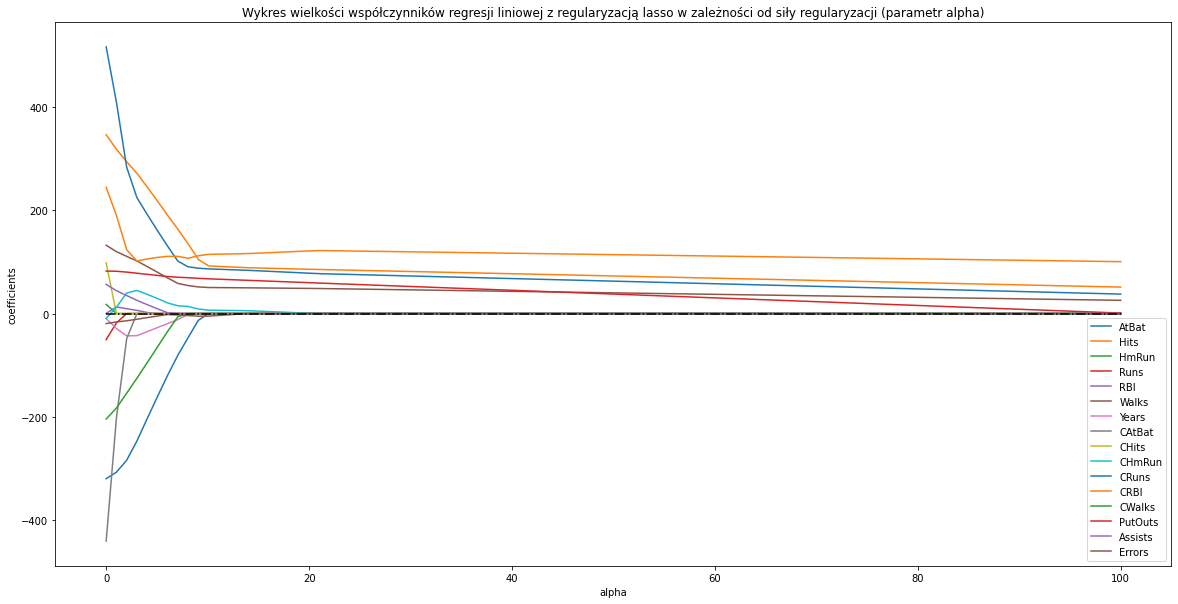

In [44]:
#2c
#patrzymy jak zmieniają się współczynniki beta ridge wraz ze wzrostem alphy 
plt.figure(figsize=(20, 10))

alpha_vec =  np.linspace(0, 100, 100)

coefs = []
for a in alpha_vec:
    model_lasso_regression = make_pipeline(
        StandardScaler(),
        Lasso(alpha = a)
    )
    model_lasso_regression.fit(X, y)
    coefs.append(model_lasso_regression.named_steps['lasso'].coef_)


plt.plot(alpha_vec, coefs)
plt.plot([np.min(alpha_vec), np.max(alpha_vec)], [0, 0], '-.', color = 'black')
plt.title('Wykres wielkości współczynników regresji liniowej z regularyzacją lasso w zależności od siły regularyzacji (parametr alpha)')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.legend(X.columns)
plt.show()

## Regresja wielomianowa z regularyzacją lasso

In [35]:
#regresja wielomianowa dla lasso
poly_lasso_estimator = make_pipeline(
    PolynomialFeatures(),
    StandardScaler(),
    Lasso(max_iter=1e3)
)
poly_lasso_estimator

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(max_iter=1000.0))])

In [31]:
#regresja lasso z optymalnymi parametrami szukanymi za pomocą Gridsearcha
grid3 = GridSearchCV(
    estimator=poly_lasso_estimator,
    param_grid={
        'polynomialfeatures__degree': [1, 2, 3],
        'lasso__alpha': np.linspace(0, 1, 10)
    },
    scoring='neg_mean_squared_error',
    cv=10
)

grid3.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso', Lasso(max_iter=1000.0))]),
             param_grid={'lasso__alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                         'polynomialfeatures__degree': [1, 2, 3]},
             scoring='neg_mean_squared_error')

In [32]:
grid3.best_params_ #najlepsze parametry

{'lasso__alpha': 0.6666666666666666, 'polynomialfeatures__degree': 2}

In [33]:
cv_model(grid3.best_estimator_, X, y) #miary obliczone za pomocą kroswalidacji, która posłużyła do znalezienia optymalnej pary parametrów, więc wynik będzie bardzo dobry,
# bo na tych samych zbiorach szukamy optymalnych parametrów, a także liczymy jeszcze raz miary dla najlepszego modelu

{'mae': 129.9529608481898, 'mse': 97241.68199458039, 'r2': 0.44419460251903936}

In [ ]:
# Zapis modelu do pliku

In [ ]:
import pickle

In [ ]:
pickle.dump(grid3, open('../grid3.pickle', 'wb'))

In [ ]:
grid4 = pickle.load(open('../grid3.pickle', 'rb'))

In [ ]:
cv_model(grid4.best_estimator_, X, y)

{'mse': 97241.68199458001,
 'mae': 129.95296084818884,
 'r2': 0.44419460251904247}

In [ ]:
def my_grid_search(estimator, params_grid, scoring='neg_mean_squared_error', cv=10):
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=params_grid,
        scoring=scoring,
        cv=cv
    )

    grid.fit(X, y)
    return grid

In [ ]:
params = {
        'polynomialfeatures__degree': [1, 2, 3],
        'lasso__alpha': np.linspace(0, 1, 10)
    }

my_grid_search(poly_lasso_estimator, params, 'r2')

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True,
                                              max_iter=1000.0, normalize=Fa...
       